##### Sprintの目的
- スクラッチを通して線形回帰を理解する
- オブジェクト指向を意識した実装に慣れる
- 数式をコードに落とし込めるようにする

スクラッチで線形回帰を実装した後、学習と検証を行なっていきます。



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

from decimal import Decimal, ROUND_HALF_UP

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

線形回帰のクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。


以下に雛形を用意してあります。このScratchLinearRegressionクラスにコードを書き加えていってください。

[(自分用メモ) 重回帰と勾配降下法](https://gneioagine.hatenablog.com/entry/20170304/1488588334)

In [2]:
class ScratchLinearRegression():
    """
    線形回帰のスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    no_bias : bool
      バイアス項を入れない場合はTrue
    verbose : bool
      学習過程を出力する場合はTrue

    Attributes
    ----------
    self.coef_ : 次の形のndarray, shape (n_features,)
      パラメータ(重み)
    self.loss : 次の形のndarray, shape (self.iter,)
      訓練データに対する損失の記録
    self.val_loss : 次の形のndarray, shape (self.iter,)
      検証データに対する損失の記録

    """
    def __init__(self, num_iter, lr=0.01, no_bias=True, verbose=False):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.no_bias = no_bias
        self.verbose = verbose
        # 損失を記録する配列を用意
        self.loss = np.zeros(self.iter)
        self.val_loss = np.zeros(self.iter)
        
    def fit(self, X, y, X_val=None, y_val=None):
        """
        線形回帰を学習する。検証データが入力された場合はそれに対する損失と精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        self.X = X
        self.X_val = X_val
        
        #バイアス項を設ける場合、左列に1の列追加
        if self.no_bias == False:
            one = np.ones(self.X.shape[0]).reshape(-1, 1)
            self.X = np.concatenate((one, self.X), axis=1)
            if X_val is not None:
                one = np.ones(self.X_val.shape[0]).reshape(-1, 1)
                self.X_val = np.concatenate((one, self.X_val), axis=1)
            
        self.coef_ = np.random.rand(self.X.shape[1]) #重み初期値：0以上1未満の乱数
        self.coef_ = self.coef_.reshape(-1, 1)
        
        for i in range(self.iter):
            #仮定関数の値（hypo_y）
            y_pred = self._linear_hypothesis(self.X)
            #誤差の算出 shape(m, 1)
            error = y_pred - y.reshape(-1, 1)
            #重みを更新
            self.coef_ = self._gradient_descent(self.X, error)
            #print(self.coef_)
            
            #目的（損失）関数の値
            self.loss[i] = self.objective_func(self.X, error)
            #検証データがある場合のloss値保存
            if X_val is not None:
                y_pred_val = self._linear_hypothesis(self.X_val)
                error_val = y_pred_val - y_val.reshape(-1, 1)
                #self.error_val = error_val
                self.val_loss[i] = self.objective_func(X_val, error_val)
        
        if self.verbose:
            #verboseをTrueにした際は学習過程を出力
            print("train_loss:\n{}".format(self.loss))
            if X_val is not None:
                print("val_loss:\n{}".format(self.val_loss))
        
    def predict(self, X):
        """
        線形回帰を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            線形回帰による推定結果
        """
        if self.no_bias == False:
            one = np.ones(X.shape[0]).reshape(-1, 1)
            X = np.concatenate((one, X), axis=1)
        
        hypo_y = self._linear_hypothesis(X)
        
        return hypo_y
    
    def _linear_hypothesis(self, X):
        """
        線形の仮定関数を計算する

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          訓練データ

        Returns
        -------
        hypo_theta：次の形のndarray, shape (n_samples, 1) Q.この形にする意味は？？
         線形の仮定関数による推定結果
         予測値が返っている
        """
        #線形回帰の仮定関数
        hypo_y = np.dot(X, self.coef_) #(-1, 1)
    
        return hypo_y
    
    def _gradient_descent(self, X, error):
        """
        重みの更新
        Parameters
        --------
        X：次の形のndarray, shape (n_samples, n_features)
            訓練データ
        error：仮定関数の値　- 実際の値(n_samples, 1)

        Returns
        --------
        new_coef_：次の形のndarray, shape (1, n_features)
        """         
        m = X.shape[0] #サンプル数
        
        new_coef_ = self.coef_ - (self.lr*(1/m)*np.dot(error.T, X).reshape(-1, 1))

        return new_coef_
    
    def objective_func(self, X, error):
        """ 
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          サンプル
        error：仮定関数の値　- 実際の値(n_samples, 1)

        Returns
        ----------
        loss : numpy.float
          平均二乗誤差/2
        """
        m = X.shape[0] #サンプルサイズ

        loss = (1/(2*m))*np.sum(np.square(error)) #float

        return loss

### 【問題1】仮定関数
以下の数式で表される線形回帰の仮定関数を実装してください。メソッドの雛形を用意してあります。

$$
h_θ(x) = θ_0x_0 + θ_1x_1 + ... + θ_jx_j + ... + θ_nx_n (x_0 = 1)
$$

x : 特徴量ベクトル

θ: パラメータベクトル

n: 特徴量の数

$x_j$ : j番目の特徴量

$θ_j$: j番目のパラメータ（重み）

特徴量の数 n は任意の値に対応できる実装にしてください。


なお、ベクトル形式で表すと以下のようになります。
$$
h_θ(x) = θ^Tx
$$


### 【問題2】最急降下法
最急降下法により学習させる実装を行なってください。  
以下の式で表されるパラメータの更新式のメソッドを追加し、fitメソッドから呼び出すようにしてください。

α: 学習率


i: サンプルのインデックス


j: 特徴量のインデックス

$$
θ_j := θ_j - α\frac{1}{m}\sum_{i=1}^{m}[(h_θ(x^{(i)}) - y^{(i)})x_j^{(i)}]
$$

### 【問題3】推定
推定する仕組みを実装してください。ScratchLinearRegressionクラスの雛形に含まれるpredictメソッドに書き加えてください。

仮定関数の出力が推定結果です。

### 【問題4】平均二乗誤差
線形回帰の指標値として用いられる平均二乗誤差（mean square error, MSE）の関数を作成してください。


平均二乗誤差関数は回帰問題全般で使える関数のため、ScratchLinearRegressionクラスのメソッドではなく、別の関数として作成してください。雛形を用意してあります。

平均二乗誤差は以下の数式で表されます。

$$
L(θ) = \frac{1}{m}\sum_{i=1}^{m}(h_θ(x^{(i)}) - y^{(i)})^2
$$

$m$ : 入力されるデータの数


$h_\theta()$ : 仮定関数


$x^{(i)}$ : i番目のサンプルの特徴量ベクトル


$y^{(i)}$ : i番目のサンプルの正解値

In [3]:
def MSE(y_pred, y):
    """
    平均二乗誤差の計算

    Parameters
    ----------
    y_pred : 次の形のndarray, shape (n_samples,)
      推定した値
    y : 次の形のndarray, shape (n_samples,)
      正解値

    Returns
    ----------
    mse : numpy.float
      平均二乗誤差
    """
    m = len(y) #サンプル数
    mse = (1/m)*np.sum(np.square(y_pred - y)) #float
    
    return mse

### 【問題5】目的関数
以下の数式で表される線形回帰の 目的関数（損失関数） を実装してください。そして、これをself.loss, self.val_lossに記録するようにしてください。

$$
J(θ) = \frac{1}{2m}\sum_{i=1}^{m}(h_θ(x^{(i)}) - y^{(i)})^2
$$

$m$ : 入力されるデータの数


$h_\theta()$ : 仮定関数


$x^{(i)}$ : i番目のサンプルの特徴量ベクトル


$y^{(i)}$ : i番目のサンプルの正解値

### 【問題6】学習と推定
機械学習スクラッチ入門のSprintで用意したHouse Pricesコンペティションのデータに対してスクラッチ実装の学習と推定を行なってください。


scikit-learnによる実装と比べ、正しく動いているかを確認してください。

In [4]:
df = pd.read_csv("train.csv")
X = df.loc[:, ["GrLivArea", "YearBuilt"]].values
y = df.loc[:, "SalePrice"].values

In [5]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
display(X)
display(y)

array([[1710, 2003],
       [1262, 1976],
       [1786, 2001],
       ...,
       [2340, 1941],
       [1078, 1950],
       [1256, 1965]])

array([208500, 181500, 223500, ..., 266500, 142125, 147500])

In [7]:
#標準化、対数変換
scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = np.log(y_train)
y_test_scaled = np.log(y_test)

/Users/itonaoki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/itonaoki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/itonaoki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/itonaoki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [8]:
model = ScratchLinearRegression(num_iter=500, lr=0.05, no_bias=False, verbose=True)

model.fit(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled)

train_loss:
[6.98982537e+01 6.30801469e+01 5.69274117e+01 5.13751043e+01
 4.63646215e+01 4.18430806e+01 3.77627615e+01 3.40806021e+01
 3.07577442e+01 2.77591223e+01 2.50530937e+01 2.26111045e+01
 2.04073874e+01 1.84186905e+01 1.66240312e+01 1.50044746e+01
 1.35429341e+01 1.22239904e+01 1.10337294e+01 9.95959443e+00
 8.99025463e+00 8.11548473e+00 7.32605733e+00 6.61364549e+00
 5.97073485e+00 5.39054433e+00 4.86695451e+00 4.39444314e+00
 3.96802678e+00 3.58320828e+00 3.23592927e+00 2.92252740e+00
 2.63969762e+00 2.38445739e+00 2.15411515e+00 1.94624195e+00
 1.75864585e+00 1.58934871e+00 1.43656545e+00 1.29868510e+00
 1.17425387e+00 1.06195980e+00 9.60618944e-01 8.69162826e-01
 7.86627227e-01 7.12141987e-01 6.44921834e-01 5.84258101e-01
 5.29511256e-01 4.80104150e-01 4.35515938e-01 3.95276581e-01
 3.58961893e-01 3.26189064e-01 2.96612628e-01 2.69920815e-01
 2.45832270e-01 2.24093079e-01 2.04474097e-01 1.86768530e-01
 1.70789755e-01 1.56369352e-01 1.43355330e-01 1.31610519e-01
 1.21011134e

In [9]:
model.predict(X_test_scaled)

array([[12.42645641],
       [11.86905465],
       [11.74042378],
       [12.30743324],
       [11.81477951],
       [11.40643476],
       [12.21786542],
       [11.74502222],
       [13.62682698],
       [12.02202668],
       [12.15683404],
       [12.13366138],
       [12.42321332],
       [11.69613901],
       [11.66884913],
       [11.83775507],
       [12.35088101],
       [11.90581018],
       [11.85078505],
       [11.83119464],
       [11.84189916],
       [11.89752199],
       [11.63043751],
       [12.14648659],
       [12.21747251],
       [11.58767444],
       [12.22837285],
       [11.58218653],
       [12.3325666 ],
       [11.72840103],
       [12.07034804],
       [12.28446664],
       [11.76946959],
       [12.53473283],
       [12.50927952],
       [12.14159378],
       [12.25314913],
       [11.71797423],
       [12.50214957],
       [12.70577737],
       [12.20854183],
       [11.8480398 ],
       [12.13011497],
       [12.38181585],
       [12.79621932],
       [12

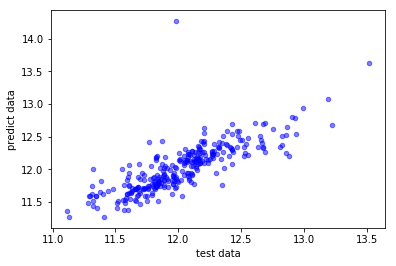

MSE:83.7048299450843


In [10]:
#ScratchLinearRegressionモデルを使った場合の予測値の散布図
#MSE

plt.xlabel("test data")
plt.ylabel("predict data")
plt.scatter(y_test_scaled, model.predict(X_test_scaled), alpha=0.5, c="b", s=20)
plt.show()

print("MSE:{}".format(MSE(model.predict(X_test_scaled), y_test_scaled)))

In [11]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train_scaled)
lr.predict(X_test_scaled)

array([12.42645641, 11.86905466, 11.74042378, 12.30743324, 11.81477951,
       11.40643476, 12.21786542, 11.74502222, 13.62682698, 12.02202668,
       12.15683404, 12.13366138, 12.42321332, 11.69613901, 11.66884913,
       11.83775507, 12.35088101, 11.90581018, 11.85078505, 11.83119464,
       11.84189916, 11.89752199, 11.63043751, 12.14648659, 12.21747251,
       11.58767444, 12.22837285, 11.58218653, 12.3325666 , 11.72840103,
       12.07034804, 12.28446664, 11.76946959, 12.53473283, 12.50927952,
       12.14159378, 12.25314913, 11.71797423, 12.50214957, 12.70577737,
       12.20854183, 11.8480398 , 12.13011497, 12.38181585, 12.79621932,
       12.08360967, 11.58579566, 11.74838306, 12.14739526, 11.58207902,
       12.78351058, 11.76867609, 11.97019217, 11.48181564, 12.19572687,
       11.7069408 , 11.60740691, 12.37079137, 11.77994118, 11.52522757,
       11.74709939, 11.70123658, 11.79952134, 11.80126831, 12.24354143,
       11.91814393, 11.64241546, 12.3418889 , 11.51819488, 12.32

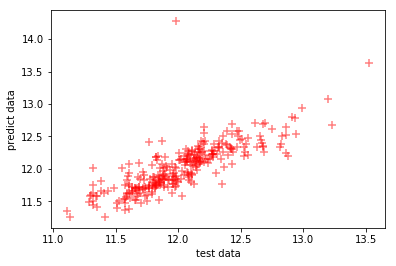

MSE:0.05730354643047342


In [12]:
#scikit-learnのLinearRegressionモデルを使った場合の予測値の散布図
#MSE

plt.xlabel("test data")
plt.ylabel("predict data")
plt.scatter(y_test_scaled, lr.predict(X_test_scaled), alpha=0.5, c="r", marker="+", s=70)
plt.show()

print("MSE:{}".format(MSE(lr.predict(X_test_scaled), y_test_scaled)))

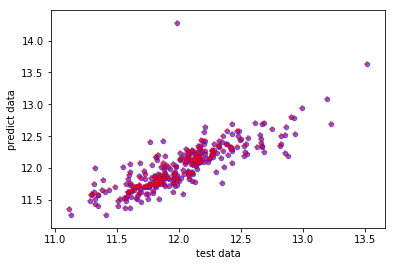

In [13]:
#重ねてみる

plt.xlabel("test data")
plt.ylabel("predict data")
plt.scatter(y_test_scaled, model.predict(X_test_scaled), alpha=0.5, c="b", s=20)
plt.scatter(y_test_scaled, lr.predict(X_test_scaled), alpha=0.5, c="r", marker="+")
plt.show()

うまく重なっているので、ScratchLinearRegressionモデルは正しく実装できていそうである。  
ただ、MSEを比べてみると結構差がある。

|--|ScratchLinearRegression|LinearRegression|
|--|--|--|
|MSE|83.70482993644858|0.05730354643047342|

### 【問題7】学習曲線のプロット
学習曲線を表示する関数を作成し、実行してください。グラフを見て損失が適切に下がっているかどうか確認してください。


線形回帰クラスの雛形ではself.loss, self.val_lossに損失を記録しておくようになっているため、入力にはこれを利用してください。

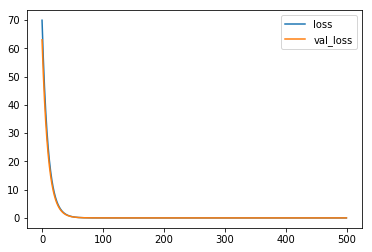

In [14]:
plt.plot(model.loss, label="loss")
plt.plot(model.val_loss, label="val_loss")
plt.legend()
plt.show()

重なっている。